In [1]:
import os
import pywt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import numpy as np
import random
from pytorch_lightning.loggers import WandbLogger
import wandb
import auraloss
import collections
from tqdm import tqdm
import pretty_midi
import matplotlib.pyplot as plt
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB
print(torch.cuda.is_available())
import plotly.graph_objects as go
from torch.optim import lr_scheduler
from IPython.display import Audio
from torchaudio.transforms import Fade
import musdb
import museval
import gc
import pandas as pd
import sklearn
from sklearn.metrics import recall_score, precision_score, f1_score, jaccard_score, accuracy_score,zero_one_loss

True


In [2]:
class Track:
    def __init__(self, name, midi_path, drum_path, mix_path):
        self.name = name
        self.midi_path = midi_path
        self.drum_path = drum_path
        self.mix_path = mix_path
        self.targets = {'drums': '', 'bass': ''}
        self.rate = 44100
        self.subset = 'test'

In [3]:
class AudioData:
    def __init__(self, audio):
        self.audio = audio

In [4]:
seed_value = 3407
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.set_float32_matmul_precision('high')

In [5]:
mix_folder = 'D:/Github/phd-drum-sep/data/MDBDrums-master/MDB Drums/audio/full_mix/'
mixes = os.listdir(mix_folder)
mixes = [mix_folder + m for m in mixes]

drum_folder = 'D:/Github/phd-drum-sep/data/MDBDrums-master/MDB Drums/audio/drum_only/'
drum = os.listdir(drum_folder)
drum = [drum_folder + d for d in drum]

beats_folder = 'D:/Github/phd-drum-sep/data/MDBDrums-master/MDB Drums/annotations/beats/'
beats = os.listdir(beats_folder)
beats = [beats_folder + b for b in beats]#

class_folder = 'D:/Github/phd-drum-sep/data/MDBDrums-master/MDB Drums/annotations/subclass/'
classes = os.listdir(class_folder)
classes = [class_folder + c for c in classes]

midi_folder = 'D:/Github/phd-drum-sep/data/MDBDrums-master/MDB Drums/midi/'
midis = os.listdir(midi_folder)
midis = [midi_folder + m for m in midis]

In [6]:
all_tracks = []
for idx, val in tqdm(enumerate(classes)):

    name = val.replace('D:/Github/phd-drum-sep/data/MDBDrums-master/MDB Drums/annotations/subclass/', '')
    name = name.replace('_subclass.txt', '')

    t = Track(name, midis[idx], drum[idx], mixes[idx])
    all_tracks.append(t)

23it [00:00, ?it/s]


In [43]:
def turn_transcription_into_roll(transcription, frames):
    # Determine your sampling frequency (frames per second)
    fs = 10
    
    piano_roll_length = int(frames)
    
    # Initialize the piano roll array
    piano_roll = np.zeros((64, piano_roll_length))
    
    # Fill in the piano roll array
    for note in transcription.instruments[0].notes:
        # Convert start and end times to frame indices
        start_frame = int(np.floor(note.start * fs))
        end_frame = int(np.ceil(note.end * fs))
        
        # Set the corresponding frames to 1 (or note.velocity for a velocity-sensitive representation)
        piano_roll[note.pitch, start_frame:end_frame] = 1  # Or use note.velocity

    ts = [[] , [], [], [], []]
    for i in range(fs):
        ts[0].append(piano_roll[35:36, :])
        ts[1].append(piano_roll[38:39, :])
        ts[2].append(piano_roll[42:43, :])
        ts[3].append(piano_roll[47:48, :])
        ts[4].append(piano_roll[49:50, :])

    roll = np.vstack([np.vstack(ts[0]),piano_roll[0:1, :], np.vstack(ts[1]),piano_roll[0:1, :],np.vstack(ts[2]),piano_roll[0:1, :],np.vstack(ts[3]),piano_roll[0:1, :],np.vstack(ts[4]), ])

    
    return roll

In [8]:
def expand(x, out_size=44100*4, step=4410):
    output_tensor = torch.zeros((5, out_size))
    for i in range(x.shape[1]):  # Iterate over the second dimension
        start_idx = i * step
        end_idx = start_idx + step
        output_tensor[:, start_idx:end_idx] = x[:, i].unsqueeze(1)
    return output_tensor

def compress(x, original_shape=(5, 40), step=4410):
    """
    Compresses a tensor from a larger size to its original smaller size by averaging blocks of values.
    
    Args:
    - x (Tensor): The input tensor to be compressed, expected to have the shape (5, 44100) or similar.
    - original_shape (tuple): The shape of the output tensor, default is (5, 40).
    - step (int): The size of the block to average over, default is 4410.
    
    Returns:
    - Tensor: The compressed tensor with shape specified by `original_shape`.
    """
    output_tensor = torch.zeros(original_shape)
    for i in range(original_shape[1]):  # Iterate over the second dimension of the target shape
        start_idx = i * step
        end_idx = start_idx + step
        # Take the mean of each block and assign it to the corresponding position in the output tensor
        output_tensor[:, i] = x[:, start_idx:end_idx].mean(dim=1)
    return output_tensor


In [9]:
def load_audio(path):
    audio_tensors = []
    waveform, _ = torchaudio.load(path)
    return waveform

def load_roll(path, frames):
    transcription = pretty_midi.PrettyMIDI(path)
    roll = turn_transcription_into_roll(transcription, frames)

    return torch.from_numpy(roll).float()


In [38]:
models = ['ht_epoch_280', 'trans_epoch_280', 'conv_epoch_200']

for m in models:
    out_dir = f"D:/Github/phd-drum-sep/model-as-adt/results_{m}/adt/"
    rows = []
    for track in tqdm(all_tracks[:1]):
    
        mixture_tensor = load_audio(track.mix_path)
        shape = mixture_tensor.shape[1]
        
        snippet_length = (mixture_tensor.shape[1] // (44100 * 4)) * (44100 * 4)
        mixture_tensor = mixture_tensor[:, :snippet_length]
    
        roll_tensor = load_roll(track.midi_path, shape)
        roll_tensor = roll_tensor[:, :snippet_length]
    
        proposed_answers = []
    
        track_dir = f'{out_dir}{track.name}'
        track_folder = os.listdir(track_dir)
        segments = len(track_folder) - 2
    
        chunk_len = int(44100 * 4)
    
        for i in range(segments):
            proposed_transcription = pd.read_csv(f'{track_dir}/{i}.csv')
            proposed_transcription = np.asarray(proposed_transcription)
            proposed_transcription = np.asarray(proposed_transcription.T)[1:].T
            proposed_transcription = expand(torch.from_numpy(proposed_transcription))
    
            start = i * chunk_len
            end = start + chunk_len
    
            drum_chunk_ = roll_tensor[:, start:end].numpy()
            proposed_transcription_ = proposed_transcription.numpy()
    break

        
                
    

    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


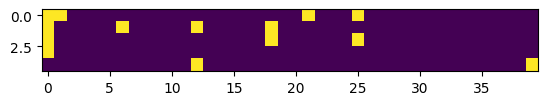

In [44]:
proposed_transcription = pd.read_csv(f'{track_dir}/{i}.csv')
proposed_transcription = np.asarray(proposed_transcription)
proposed_transcription = np.asarray(proposed_transcription.T)[1:].T
plt.imshow(proposed_transcription)

In [45]:
mixture_tensor = load_audio(track.mix_path)
shape = (mixture_tensor.shape[1] // 44100) * 10
roll_tensor = load_roll(track.midi_path, shape)

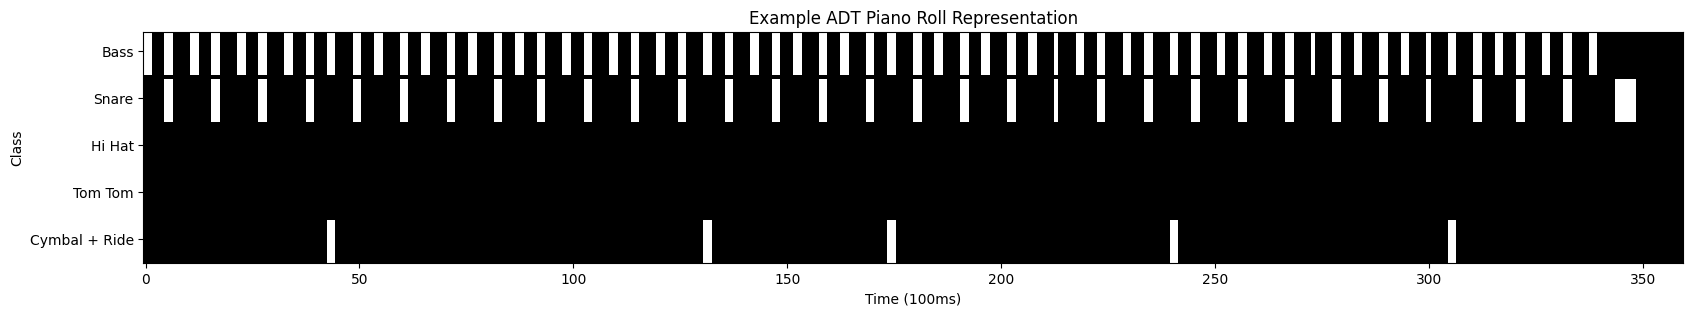

In [139]:
plt.figure(figsize=(20, 3))
plt.yticks([4,15,26,37,48], ["Bass", "Snare", "Hi Hat", "Tom Tom", "Cymbal + Ride"])
plt.imshow(roll_tensor[:roll_tensor.shape[1]], cmap='gray')
plt.xlabel("Time (100ms)")
plt.ylabel("Class")
plt.title("Example ADT Piano Roll Representation")
plt.savefig("roll.png")
plt.show()

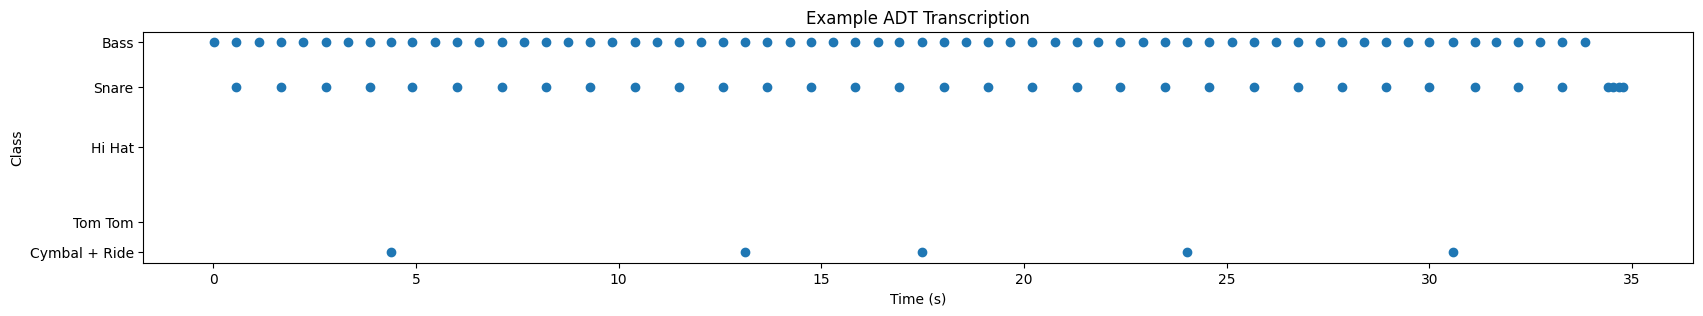

In [140]:
plt.figure(figsize=(20, 3))

transcription = pretty_midi.PrettyMIDI(midis[0])
plt.scatter([note.start for note in transcription.instruments[0].notes], [note.pitch for note in transcription.instruments[0].notes])
plt.yticks([35, 38, 42, 47, 49], ["Bass", "Snare", "Hi Hat", "Tom Tom", "Cymbal + Ride"])
plt.gca().invert_yaxis()
plt.xlabel("Time (s)")
plt.ylabel("Class")
plt.title("Example ADT Transcription")
plt.savefig("transcription.png")
plt.show()

In [131]:
audio, _ = torchaudio.load(mixes[0])
transform = torchaudio.transforms.Resample(44100, 10)
audio = transform(audio)
audio.numpy()

array([[ 6.12995864e-05, -1.59414150e-04, -8.42917143e-05,
        -1.84175660e-04,  6.76729178e-05,  1.81759766e-04,
         1.05304155e-03,  1.54374843e-03,  8.79858795e-04,
         2.44404800e-04,  1.24804492e-05,  7.32008775e-05,
        -2.88315023e-05, -9.50349786e-05,  1.49124317e-04,
        -6.33840100e-05,  1.90202945e-06,  8.95423655e-05,
        -2.02458963e-04,  1.36621995e-04,  9.62747799e-06,
        -3.40267616e-05, -9.28912195e-05, -1.47630824e-04,
        -1.17013068e-03, -1.86867067e-06, -3.23247397e-04,
        -7.64412805e-04, -2.11114413e-04,  3.66333588e-05,
        -2.37961012e-05,  5.58093088e-05,  3.71992064e-04,
        -8.67426745e-04, -1.21608318e-03, -5.17543522e-04,
         2.61900481e-04, -5.70847711e-04, -5.48373442e-04,
        -3.20256426e-04,  7.97527260e-04,  4.88611113e-04,
         1.36878080e-04, -2.75761966e-04, -7.49975909e-04,
        -7.41790514e-04, -2.32613558e-04, -1.05095591e-04,
        -1.56495080e-04,  1.43804689e-04, -1.75456473e-0

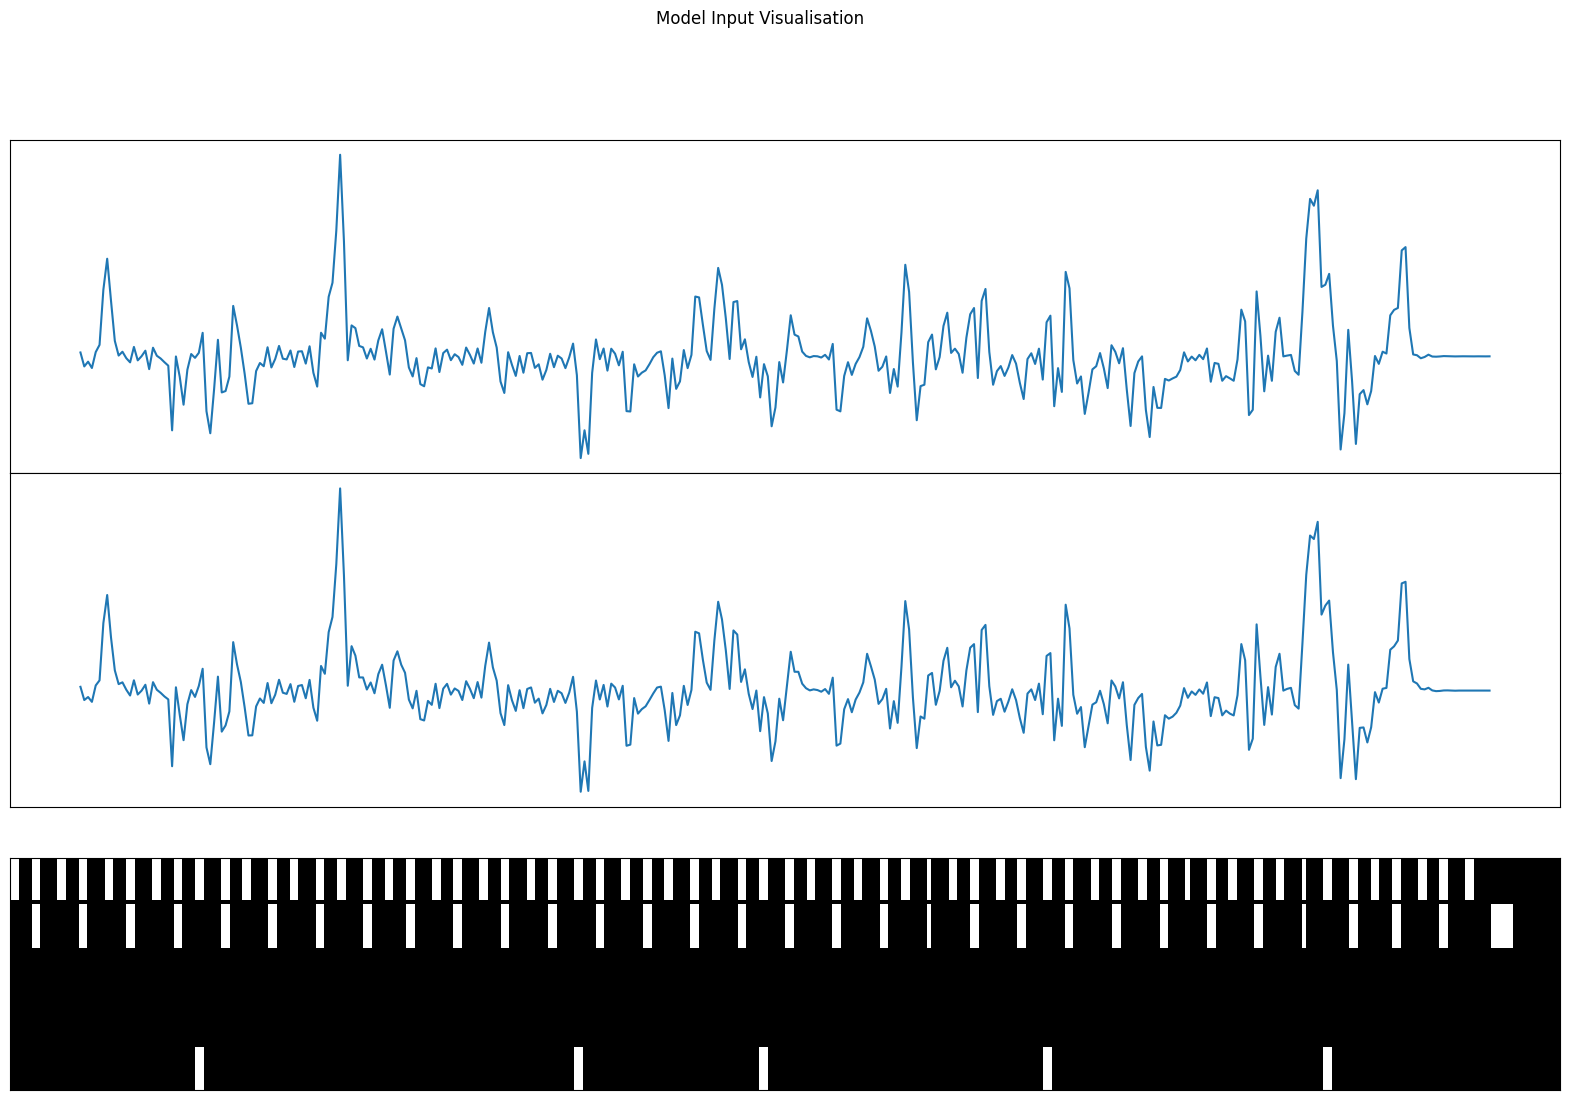

In [141]:
f, axarr = plt.subplots(3, 1, figsize=(20, 13))
f.suptitle("Model Input Visualisation")
axarr[0].plot(audio[0])
axarr[1].plot(audio[1])
axarr[2].imshow(roll_tensor[:roll_tensor.shape[1]], cmap='gray')
axarr[0].axes.get_xaxis().set_visible(False)
axarr[1].axes.get_xaxis().set_visible(False)
axarr[2].axes.get_xaxis().set_visible(False)
axarr[0].axes.get_yaxis().set_visible(False)
axarr[1].axes.get_yaxis().set_visible(False)
axarr[2].axes.get_yaxis().set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("model_input.png")
plt.show()